<a href="https://colab.research.google.com/github/ShynPham/pytorch_learning_journey/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ask yourself a few questions.

> What happend if your models performace is poor?

> Do anybody have the same idea of what I did?

> If yes, there must be a well-perforrming model that already exist out there right?

Often the answer is yes in deep learing world. And there is one powerful technique called *transfer learning*.

# 0. Transfer Learning and what is it about.

Transfer learning allows us to take the patterns(also called weights) on another model has learned from another problem and apply it to our own problem.

> For example, we can take a patterns a computer vision model has learned from datasets such as [ImageNet](https://www.image-net.org/index.php) and use them to power our FoodVision Mini model

> Or we can take the patterns from a [language model](https://developers.google.com/machine-learning/glossary/language#m) and use them as the basic of a model to classofy different text sample

* The premise remain the same, find a good existing model, apply it to our own problem

A few popular website example of pretrained models:
* [PyTorch domain library](https://pytorch.org/domains/)
* [HuggingFace hub](https://huggingface.co/models)
* [`timm`(PyTorch Image Models) library](https://github.com/huggingface/pytorch-image-models)
* [Paperswithcode](https://paperswithcode.com/)





## 0.1 To save sometime, we'll be uising the code that we setup from 05_going_modular

Specifically, we're going to download the `going_modular` directory

We will also get the `torchinfo` package if it's not available


In [ ]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 1.12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 0.13, "torchvision version should be v0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [ ]:
# Continue with the regular imports

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torch info, install it it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo, installing it...")
  !pip install -q torchinfo
  from torchinfo import summary

In [ ]:
# Try to import going_modular directory, downloading from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
except:
  # Get the going_modular script
  print("[INFO] Couldn't fing going_modular, downloading it...")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

Before we can do any transfer learning, we'll need a datasets. Let's write some code to download `pizza_steak_sushi` datasets


In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exits, we downloading it.
if image_path.is_dir():
  print(f"{image_path} directory is already exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Downloading pizza steak sushi datasets
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip the datasets
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove the zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory is already exists


In [ ]:
# Setup directory for train and test path
train_dir = image_path / "train"
test_dir =  image_path / "test"

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Train directory: data/pizza_steak_sushi/train
Test directory: data/pizza_steak_sushi/test


## 2. Create Datasets and DataLoaders

Since we'll using a pretrained model from `torchvision.models`, there will be a specific transform we need to prepare our image first



### 2.1 Creating a transform for `torchvision.models`(manual creation)

When using a pretrained models, it is important that *your custom data going into the model is prepared in the same way as the original training data that went into the model*

With the torchvision v0.13+, you can use the following transform to normalize:

```
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

To achieve the above transformatons, we can use a combination of:

| **Transform number** | **Transform required** | **Code to perform transform** |
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  |


Let's compose a seris of `torchvision.transform` to perform above step

### Be in mind, the **mean** and **std** number that we get for **Normalize** is a standard pratice of ImageNet. The value is caculated base on millions of training datasets and considered to be common pratice when use with **Normalize**.

In [ ]:
 # Create a transforms pipeline manually
 manual_transforms = transforms.Compose([
     transforms.Resize((224, 224)), # 1. Resize the image to 224x224
     transforms.ToTensor(), # 2. Turn image values to between 0 & 1
     transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. adjust the mean of our image
                          std=[0.229, 0.224, 0.225]) # 4. Adjust std
 ])

In [ ]:
# Create training and testing DataLoaders as well as a list of class name
train_dataloader, test_dataloader , class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=manual_transforms,
                                                                                batch_size=32) # We will use batch_size of minimum is 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x787b191534d0>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Creating a transform for `torchvision.models`(auto creation)

As of `torchvision` v0.13+, an automic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, we will use the following code:

```
weight = torchvision.models.EfficientNet_B0_Weight.DEFAULT
```

Where,

* `EfficientBet_B0_Weight` is a model architecture we'd like to use(there are more models architecture we can use, [check it out here](https://docs.pytorch.org/vision/main/models/efficientnet.html).
* `DEFAULT` means it is the best available weights(according to ImageNet)




In [ ]:
# Get a set of pretranined model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained model
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Notice how `ImageClassification` and our `manual_transforms` are very similiar to each other, the only different that `auto_transforms` came with the model architectures that we chose, where as we have to create `manual_transforms` by hand.

In [ ]:
# We also can use `auto_transforms` to create DataLoader

# Create training and testing data and class name
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=auto_transforms,
                                                                                batch_size=32)
#

# 3. Getting a pretrained model

The whole idea of transfer learning is **take an already existing well-performce model on a similiar problems and apply it onto our own problems and customize it in your case**.

Since we're working on computer vision model, there are plenties classification models in `torchvision.models`. Below are common computer vision architecutre backbones:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... |
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` |
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... |
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... |
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` |


## 3.1 The questions is what pre-train model should I use?

It depend on the problem that you're working with.

Generally, the **higher number** in the model name(e.g `EfficientNet_B0`, `EfficientNet_B1,...`), mean the **better** performance is but it is also come with a **larger model**.

Although better performance is generally good but to **sometimes, better mean too big for some devices**

So to answer the question what model should we use, we likely to get the biggest, most compute hungry model that your computer or the compute platform can handle.

Understanding this **performance vs speed vs size** tradeoff will come with time and practice

## 3.2 Setting up pretrained model

The train model we will be using is `torchvision.models.efficientnet_b0()` ([source](https://arxiv.org/abs/1905.11946))

In [ ]:
# Setting up model with pretained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# model

### The `efficientnet_b0` come in three main part:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data
2. `avgpool` - Take an average oft the output of the `feature` layer(s) and turn it into **feature vector**
3. `classifier` - Turn the **feature vector** into a vector with the same dimensionality as the nmber of required ourput class

We'll do coding to apply and understanding what those mean.

## 3.3 Getting a summary of our model with `torchinfo.summary()`

We will be using `torchinfo.summary()` to learn more about our model

To do so, we'll pass in:
* `model` - the model we'd like to get a summar of
* `input_size` - the shape of the data we'd like to pass to our model(in this case of `efficientnet_b0, the input size is `(batch_size, 3, 224, 224))`. Different model different input
* `col_names` - the various information columns we'd like to see about the models
*`row_settings` - what features to show in a row


In [ ]:
summary(model=model,
                  input_size=(32, 3, 224, 224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

## 3.4 Freezing the base model and changing the output layer to suit our needs.

The process of transfer learning go: freeze some base layer of a pretrain models -> adjust the output layer to suit your needs.


The original `out_features` of `torchvison.models.efficientnetb0()` is 1000 because there are 1000 classes in ImageNet. But for ours, we could change it into 3 `out_features=3`.

> NOTE: To *freeze* layeres mean to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layer during training, keep them how they're"

To freeze all of the layers/parameters in the `features` sections by settings the attribute `requires_grad=False`

In [ ]:
# Freeze all base layers in the "features" sections of the model
for params in model.features.parameters():
  params.requires_grad = False

### Now we changing the `out_feature=1000` to `out_features=3` since we only have 3 classes

In [ ]:
# Checking the current classifier
classifier = model.classifier
classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# Making a new classifier class with different out_features

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the lengths of class name
output_shape = len(class_names)

# Create a new classifier
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [ ]:
# Do a summary check after changing the output
summary(model=model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### As we can see, in a `trainable` columns many was set to Failed while our classifier was set to True, this is because we froze most of the paramaters and only create a base representation of our inpit image to feed into our `classififer` model

# 4. Train model
 What we've done so far:

1. Semi-frozen model
2. Change the output layers to fit our needs_sqlite

Now we will be making loss function and optimizer.

For loss functions, since this is a multi-classification model  we'll be using `nn.CrossEnntropyLoss()`

For optimizer, we will stick with `torch.optim.Adam()` with the lr=0.001


In [ ]:
# Defind loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Use the engine.py to train our model

# Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer
end_time = timer()
# print out what's happening
print(f"[INFO] Total training time {end_time - start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time  13.456 seconds


# 5. Evaluate the model by plotting the curves

We'll use the function that create in notebook 04 `plot_loss_curve()` to see how is our model training look overtime.

The function is store in `helper_function.py` script so we will import it

In [ ]:
# Get the plot_loss_curve() function from helper_functions.py, download if there is none

try:
  print("helper_functions is already install.")
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading it...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    print("Downloading helper_functions.py...")
    f.write(request.content)
  from helper_functions import plot_loss_curves

helper_functions is already install.


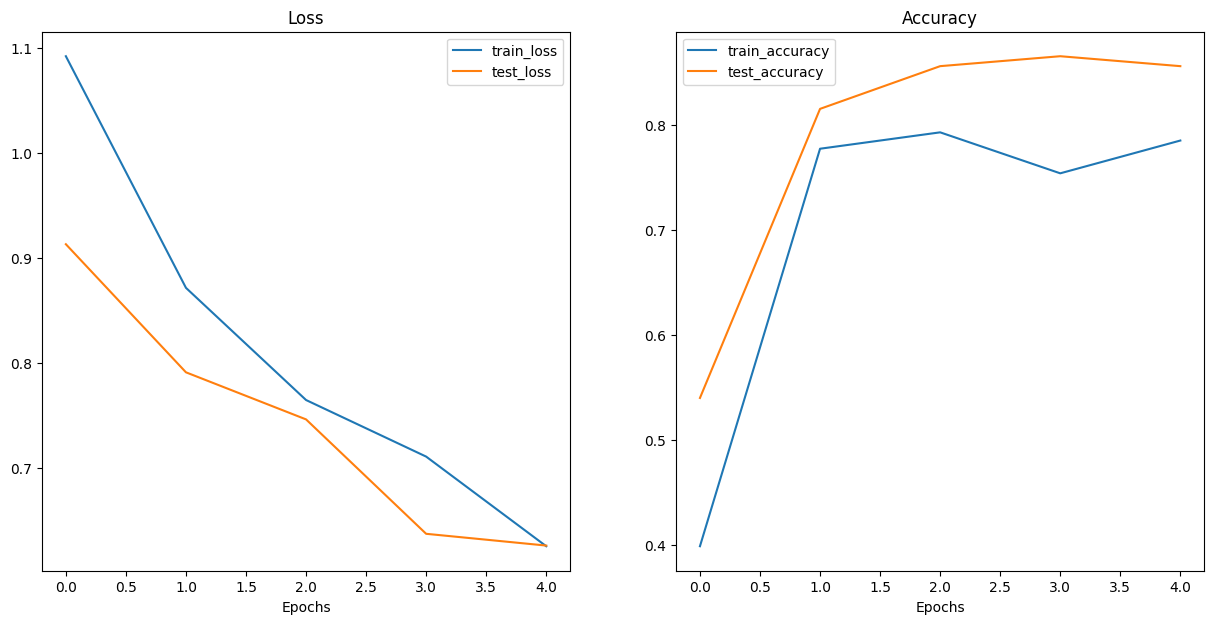

In [ ]:
plot_loss_curves(results)


# 6. Make predictions on images from the test set

From the look of our model performing, it doing well on quantitively but how about qualitatively

Let's find out by making some predictions with images from the test set, and to be able to do it, we need to make sure our images have:

* **Same Shape**: This is one of the 3 main reason why the model isn't working properly, so making sure the images and our models are in the same shapes.
* **Same datatype**: The second out of 3 main reason, data and model must have the same datatype(e.g `torch.int8` or `torch.float32`)
* **Same device**): The third out of 3 main reason, data and model must be on the same device(e.g cpu or cuda)
* **Same transformation**: This won't be apply for every model but if our model is trained on images that have been transformed in certain way, and then we try to make prediction on images transformed in a different way, these predictions may be off.


---


To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath, an image size, a transform and a target device
2. Open an image with `PIL.image.open()`
3. Create a transform for the images(can use `manual_transforms` or `weight_transforms()`
4. Make sure the model is on target device
5. Turn mode into `eval.mode()`
6. Transform the target images and add an extra batch
7. Make a prediction
8. Convert models output logit to preds probs(using `torch.softmax()`)
9. Convert preds probs to preds labels(using `torch.argmax()`)
10. Plot the images with `matplotlib` and set the title

---

In [ ]:
# 1. Making a function taking model, classname, filepath, image size, transform and target device
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
from typing import List, Tuple
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        classname: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the image
  img = Image.open(image_path)

  # 3. Create a transform
  if transform is not None:
    image_transform = transform
  else:
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    image_transform = weights.transforms()

  # 4. Makeing sure the target is on the target device
  model.to(device)

  # 5. Turn on model eval mode and inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform images and add an extra batch
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make a prediction
    target_image_pred = model(transformed_image.to(device))

    # 8. Convert model output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot using matplotlib
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {classname[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

  # Debugging
  print(f"Raw model output: {target_image_pred}")
  print(f"Results of argmax output {target_image_pred_label}")
  print(f"Tensor shape: {target_image_pred_probs.shape}")
  print(f"Pred Prob: {target_image_pred_probs.max()}")

Raw model output: tensor([[-1.0811, -0.6630,  1.0445]], device='cuda:0')
Results of argmax output tensor([2], device='cuda:0')
Tensor shape: torch.Size([1, 3])
Pred Prob: 0.768835186958313
Raw model output: tensor([[ 0.7116, -0.4984, -1.0597]], device='cuda:0')
Results of argmax output tensor([0], device='cuda:0')
Tensor shape: torch.Size([1, 3])
Pred Prob: 0.6810498237609863


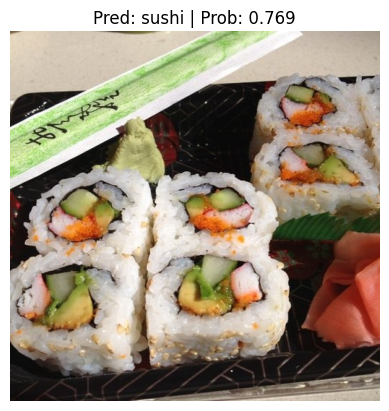

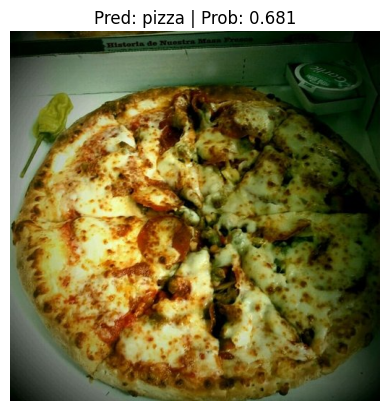

In [ ]:
# Get images
num_images = 2
test_image = list(Path(test_dir).glob("*/*.jpg"))
random.shuffle(test_image)

# Make prediction on the images
for image_path in test_image[:num_images]:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      classname=class_names)